## To calculate the IMPACT score and to refit a logistic regression on our cohort to get the IMPACT-score-Necker.

We automatically extracted the data of 3081 patients hospitalised in Necker hospital for a heart catheterization between 2010 and 2016.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Procedure date, patient weight, and hemodynamic

In [3]:
df_KTTR = pd.read_csv('KTTR', sep = ";", encoding = "utf-8", parse_dates=['Date document'])
df_KTTR['RVP'] = df_KTTR['RVP'].str.replace(',', '.', regex=True)
df_KTTR['QPQS'] = df_KTTR['QPQS'].str.replace(',', '.', regex=True)
df_KTTR['POIDS'] = df_KTTR['POIDS'].str.replace(',', '.', regex=True)
df_KTTR[['RVP', 'QPQS', 'POIDS']] = df_KTTR[['RVP', 'QPQS', 'POIDS']].astype(float)

# Remove aberante weight
df_KTTR.loc[(df_KTTR['POIDS'] < 0), 'POIDS'] = np.nan
df_KTTR.loc[(df_KTTR['POIDS'] > 200), 'POIDS'] = np.nan

# Remove procedures after 2016 and before 2010
df_KTTR = df_KTTR[(df_KTTR["Date document"].dt.year < 2017) & (df_KTTR["Date document"].dt.year > 2009)]

In [4]:
#df_KTTR['IPP'].groupby(df_KTTR["Date document"].dt.year).count().plot(kind="bar", legend=None)
#plt.show()
#print(df_KTTR.info())
#print('_________________________________________________')
#print(df_KTTR.nunique())

## Type of procedure

In [5]:
df_tdk = pd.read_csv('TDK.csv', sep = ";", encoding = "utf-8", parse_dates=['Date document'])

In [6]:
#print(df_tdk.info())
#print('_________________________________________________')
#print(df_tdk.nunique())

In [7]:
# Keep only first REGEX
df_tdk.columns = ['IPP', 'DDDoc', 'TDK']
df_tdk['TDK1'], df_tdk['TDK2'] = df_tdk['TDK'].str.split(';', 1).str
df_tdk = df_tdk[['IPP', 'DDDoc', 'TDK1']]

# Remove spaces at the end a string
df_tdk.TDK1 = df_tdk.TDK1.str.rstrip()

In [8]:
# Merge KTTR & TDK on IPP (left-join on KTTR)
df = pd.merge(df_KTTR,
               df_tdk,
               left_on='IPP',
               right_on='IPP',
               how='left')

# Set date document and DDDoc as dates
df['DDDoc'] = pd.to_datetime(df['DDDoc'])
df['Date document'] = pd.to_datetime(df['Date document'])

#df.head(5)

In [9]:
# Create time laps column = time between KT and TDK1
df['time_laps'] = abs(df['Date document'] - df['DDDoc'])

# Select the closest TDK1 to Date document 
df = df.sort_values(['time_laps']).drop_duplicates(subset='IPP')

# Select TDK1 that are within 20 days of the DDKT
df['time_laps'] = df['time_laps'] <= pd.Timedelta(20,'D')

# Replace TDK1 by NaN if time_laps > 20 jours
df.loc[df['time_laps'] == False, 'TDK1'] = np.nan

# Merge KTTR & df(TDK) on IPP (left-join on KTTR)
df_KTTR_TDK = pd.merge(df_KTTR,
               df[['IPP', 'TDK1']],
               left_on='IPP',
               right_on='IPP',
               how='left')

# Keep the first procedure for each patient.
df_KTTR_TDK = df_KTTR_TDK.sort_values(['Date document']).drop_duplicates(subset='IPP')

#print(df['time_laps'].describe())
#print(df['IPP'].nunique())
#print(df.head(5))
#print(df.info())
#df_KTTR_TDK['IPP'].groupby(df_KTTR_TDK["Date document"].dt.year).count().plot(kind="bar", legend=None)
#plt.show()

## Medical background

In [10]:
# df_ATCD
df_ATCD = pd.read_csv('ATCD.csv', sep = ";", encoding = "utf-8")
df_ATCD=df_ATCD[['IPP', 'Insuffisance rénale', 'Univentriculaire', 'Traitement influent sur la coagulation']]

# Grouby IPP (num patient) and if the variable is True once, it makes it always True
df_ATCD = df_ATCD.fillna(False)
df_ATCD = df_ATCD.groupby(by='IPP', as_index=False).any()
df_ATCD = df_ATCD[['IPP', 'Insuffisance rénale', 'Univentriculaire', 'Traitement influent sur la coagulation']]

In [11]:
# Merge df_KTTR_TDK & df_ATCD
df_KTTR_TDK_ATCD = pd.merge(df_KTTR_TDK,
                           df_ATCD,
                           left_on='IPP',
                           right_on='IPP',
                           how='left')

#print(df_KTTR_TDK_ATCD.head(5))
#print(df_KTTR_TDK_ATCD.info())

## Biology Results

In [12]:
# Platelet
plq = pd.read_csv('plaquettes.csv', sep=';', encoding='utf-8', parse_dates=['DDBio'])
plq.loc[(plq['PLQ'] < 10), 'PLQ'] = np.nan
plq.loc[(plq['PLQ'] > 800), 'PLQ'] = np.nan

df_kta_PLQ = pd.merge(df_KTTR_TDK_ATCD,
                   plq[['IPP', 'DDBio', 'PLQ']],
                   how='left',
                     on='IPP')

df_kta_PLQ['time_laps'] = (df_kta_PLQ['Date document'] - df_kta_PLQ['DDBio']
                          ).replace(np.nan, pd.Timedelta(0,'D'), regex=True)

df_kta_PLQ.loc[(df_kta_PLQ['time_laps'] >= pd.Timedelta(0,'D')) & (df_kta_PLQ['time_laps'] <= pd.Timedelta(30,'D'))]


df_kta_PLQ = df_kta_PLQ.sort_values(['time_laps']).drop_duplicates(subset='IPP')

df_kta_PLQ = df_kta_PLQ[['IPP', 'Date document', 'sexe', 'POIDS', 'PTDVG', 'RVP', 'QPQS', 'PAPM',
       'PAPS', 'SVO2', 'SAT', 'TDK1', 'Insuffisance rénale',
       'Univentriculaire', 'Traitement influent sur la coagulation', 'PLQ']]

#print(df_kta_PLQ.describe())
#print(df_kta_PLQ.info())
#print(df_kta_PLQ.head(n=5))
#print('Nombre de patients', df_kta_PLQ['IPP'].nunique())

In [13]:
# Fibrinogen
fbg = pd.read_csv('fbg.csv', sep=';', encoding='utf-8', parse_dates=['DDBio'])

fbg = fbg.rename(columns={'FBG1':'FBG'})

df_kta_PLQ_FBG = pd.merge(df_kta_PLQ,
                  fbg[['IPP', 'DDBio', 'FBG']],
                   left_on='IPP',
                   right_on='IPP',
                   how='left')

df_kta_PLQ_FBG['time_laps'] = (df_kta_PLQ_FBG['Date document'] - df_kta_PLQ_FBG['DDBio']
                              ).replace(np.nan, pd.Timedelta(0,'D'), regex=True)

df_kta_PLQ_FBG.loc[(df_kta_PLQ_FBG['time_laps'] >= pd.Timedelta(0,'D')) & (df_kta_PLQ_FBG['time_laps'] <= pd.Timedelta(30,'D'))]

df_kta_PLQ_FBG = df_kta_PLQ_FBG.sort_values(['time_laps']).drop_duplicates(subset='IPP')

df_kta_PLQ_FBG = df_kta_PLQ_FBG[['IPP', 'Date document', 'sexe', 'POIDS', 'PTDVG', 'RVP', 'QPQS', 'PAPM',
       'PAPS', 'SVO2', 'SAT', 'TDK1', 'Insuffisance rénale',
       'Univentriculaire', 'Traitement influent sur la coagulation', 'PLQ', 'FBG']]

#print(df_kta_PLQ_FBG.describe())
#print(df_kta_PLQ_FBG.info())
#print(df_kta_PLQ_FBG.head(n=5))
#print('Nombre de patients', df_kta_PLQ_FBG['IPP'].nunique())

In [14]:
# TP

tp = pd.read_csv('tp.csv', sep=';', encoding='utf-8', parse_dates=['DDBio'])


df_kta_PLQ_FBG_TP = pd.merge(df_kta_PLQ_FBG,
                  tp[['IPP', 'DDBio', 'TP']],
                   left_on='IPP',
                   right_on='IPP',
                   how='left')

df_kta_PLQ_FBG_TP['time_laps'] = (df_kta_PLQ_FBG_TP['Date document'] - df_kta_PLQ_FBG_TP['DDBio']
                              ).replace(np.nan, pd.Timedelta(0,'D'), regex=True)

df_kta_PLQ_FBG_TP.loc[(df_kta_PLQ_FBG_TP['time_laps'] >= pd.Timedelta(0,'D')) & (df_kta_PLQ_FBG_TP['time_laps'] <= pd.Timedelta(30,'D'))]

df_kta_PLQ_FBG_TP = df_kta_PLQ_FBG_TP.sort_values(['time_laps']).drop_duplicates(subset='IPP')


df_kta_PLQ_FBG_TP = df_kta_PLQ_FBG_TP[['IPP', 'Date document', 'sexe', 'POIDS', 'PTDVG', 'RVP', 'QPQS', 'PAPM',
       'PAPS', 'SVO2', 'SAT', 'TDK1', 'Insuffisance rénale',
       'Univentriculaire', 'Traitement influent sur la coagulation', 'PLQ', 'FBG', 'TP']]

#print(df_kta_PLQ_FBG_TP.describe())
#print(df_kta_PLQ_FBG_TP.info())
#print(df_kta_PLQ_FBG_TP.head(n=5))
#print('Nombre de patients', df_kta_PLQ_FBG_TP['IPP'].nunique())

In [15]:
# TCA

tca = pd.read_csv('tca.csv', sep=';', encoding='utf-8', parse_dates=['DDBio'])


df_kta_PLQ_FBG_TP_TCA = pd.merge(df_kta_PLQ_FBG_TP,
                  tca[['IPP', 'DDBio', 'TCA']],
                   left_on='IPP',
                   right_on='IPP',
                   how='left')

df_kta_PLQ_FBG_TP_TCA['time_laps'] = (df_kta_PLQ_FBG_TP_TCA['Date document'] - df_kta_PLQ_FBG_TP_TCA['DDBio']
                              ).replace(np.nan, pd.Timedelta(0,'D'), regex=True)

df_kta_PLQ_FBG_TP_TCA.loc[(df_kta_PLQ_FBG_TP_TCA['time_laps'] >= pd.Timedelta(0,'D')) & (df_kta_PLQ_FBG_TP_TCA['time_laps'] <= pd.Timedelta(30,'D'))]

df_kta_PLQ_FBG_TP_TCA = df_kta_PLQ_FBG_TP_TCA.sort_values(['time_laps']).drop_duplicates(subset='IPP')


df_kta_PLQ_FBG_TP_TCA = df_kta_PLQ_FBG_TP_TCA[['IPP', 'Date document', 'sexe', 'POIDS', 'PTDVG', 'RVP', 'QPQS', 'PAPM',
       'PAPS', 'SVO2', 'SAT', 'TDK1', 'Insuffisance rénale',
       'Univentriculaire', 'Traitement influent sur la coagulation', 'PLQ', 'FBG', 'TP', 'TCA']]

#print(df_kta_PLQ_FBG_TP_TCA.describe())
#print(df_kta_PLQ_FBG_TP_TCA.info())
#print(df_kta_PLQ_FBG_TP_TCA.head(n=5))
#print('Nombre de patients', df_kta_PLQ_FBG_TP_TCA['IPP'].nunique())

In [16]:
df_ktas = df_kta_PLQ_FBG_TP_TCA

#print(df_ktas.head(5))
#print(df_ktas['TDK1'].unique())

## Age on the day of the catheterization

In [17]:
ddn = pd.read_csv('DDN.csv', sep = ";", encoding = "utf-8", parse_dates=['BIRTH_DATE'], dayfirst=True)
ddn.rename(columns={'BIRTH_DATE':'DDN', 'DWH ID':'IPP'}, inplace=True)

# remove future birth dates (abberante values)
ddn = ddn.loc[~(ddn.DDN > dt.datetime.today())]

# Merge with df_ktas
df_ktasn = pd.merge(
    df_ktas,
    ddn,
    on='IPP',
    how='left')

# Calculate the age on the day of the catheterization

df_ktasn['KT_AGE'] = df_ktasn['Date document'] - df_ktasn['DDN']

# remove aberrant ages 
df_ktasn = df_ktasn.loc[~(df_ktasn.KT_AGE < dt.timedelta(days=0))]

#print(df_ktasn.info())

## Adverse events

In [18]:
## Matching the complication table with the correspondence table

# correspondence table
tbl_cf = pd.read_csv('table_de_correspondance.csv', 
                     sep=";", 
                     encoding="utf-8", 
                    index_col=0)

# print(tbl_cf)
# should be 17712 rows long

In [19]:
# Result table (unlab_classifier_exemples_positifs_verifie is the table where 
# I checked every positive complications)
df_RESULT = pd.read_csv('unlab_classifier_exemple_positifs_verifies.csv', 
                        sep=";", encoding="utf-8")
df_RESULT['index'] = df_RESULT['index'].str.extract('(\d+)')

In [20]:
# add train, test, dev result

df_train = pd.read_csv('train.csv', 
                        sep=";", encoding="utf-8",
                      usecols=['index', 'label'])
df_train['index'] = df_train['index'].str.extract('(\d+)')
df_train.rename(columns={'label': 'result'}, inplace=True)

df_test = pd.read_csv('test.csv', 
                        sep=";", encoding="utf-8",
                      usecols=['index', 'label'])
df_test['index'] = df_test['index'].str.extract('(\d+)')
df_test.rename(columns={'label': 'result'}, inplace=True)

df_dev = pd.read_csv('dev.csv', 
                        sep=";", encoding="utf-8",
                      usecols=['index', 'label'])
df_dev['index'] = df_dev['index'].str.extract('(\d+)')
df_dev.rename(columns={'label': 'result'}, inplace=True)

In [21]:
df_RESULT = pd.concat([df_RESULT, df_train, df_test, df_dev])

df_RESULT.to_csv('result_test.csv', sep=';', encoding='utf-8' )

#print(df_RESULT['index'].nunique())

In [22]:
# set index as int64

df_RESULT = df_RESULT.astype({'index': 'int64'})

df_RESULT = df_RESULT.set_index('index')

# merge

df_merge = tbl_cf.merge(df_RESULT, left_index=True, right_index=True)

#print(df_merge)
#print('merge', df_merge['result'].value_counts())
#print('result', df_RESULT['result'].value_counts())

In [23]:
df_merge.to_csv('merge_test.csv', sep=';', encoding='utf-8' )

In [24]:
df_RESULT = df_merge[['IPP', 'result', 'DDK']].dropna()
df_RESULT.loc[:,'result'] = df_RESULT['result'].astype(int)
df_RESULT = df_RESULT[['IPP', 'result']]
df_RESULT = df_RESULT.groupby('IPP').sum()
#print(df_RESULT['result'].value_counts())

df_ktasnr = pd.merge(df_ktasn,
                     df_RESULT,
                     left_on='IPP',
                     right_on='IPP',
                     how='left')


#print(df_ktasnr['IPP'].nunique())
#print(df_ktasnr['result'].value_counts())
#print(df_ktasnr.groupby(df_ktasnr["Date document"].dt.year).count().plot(kind="bar", legend=None))
#print()

In [25]:
df_ktasn.to_csv('df_ktasn.csv', sep=';', encoding='utf-8')

In [26]:
# ktasnr is the final result of our automatically extracted protocol
# ktasnr.csv will be used to describe missing data, and patient characteristics

df_ktasnr['result'][df_ktasnr['result'] > 0] = 1
df_ktasnr.to_csv('ktasnr.csv', sep=';', encoding='utf-8')
df_ktasnr['result'].value_counts()

# to save datas before replace missing values: 
data_extract = df_ktasnr

# Replace missing data with normal values

In [27]:
# we replace missing weights by a weight that will not influence the score (7 kg)

df_ktasnr.loc[:,'POIDS'] = df_ktasnr['POIDS'].fillna(7)

In [28]:
# same thing for the cath type: Cathétérisme diagnostique does not influence the score

df_ktasnr.loc[:,'TDK1'] = df_ktasnr['TDK1'].fillna('Cathétérisme diagnostique')

In [29]:
# if there is no mention in the text, 
# we considered that the patient does not have the antecedent

df_ktasnr = df_ktasnr.fillna({'Insuffisance rénale':False, 
                              'Univentriculaire' :False, 
                              'Traitement influent sur la coagulation' : False})

In [30]:
# Missing biology data are replace with normal values

df_ktasnr.loc[:,'PLQ'] = df_ktasnr['PLQ'].fillna(250)
df_ktasnr.loc[:,'TCA'] = df_ktasnr['TCA'].fillna(1)
df_ktasnr.loc[:,'TP'] = df_ktasnr['TP'].fillna(80)
df_ktasnr.loc[:,'FBG'] = df_ktasnr['FBG'].fillna(2)

In [31]:
# if there is no mention in the text, 
# we considered that the patient did not undergone MAE

df_ktasnr.loc[:,'result'] = df_ktasnr['result'].fillna(0)

print(df_ktasnr['result'].value_counts())

0.0    2706
1.0     189
Name: result, dtype: int64


In [32]:
# we replace missing age by 365 days because that will not influence the score

df_ktasnr.loc[:,'KT_AGE'] = df_ktasnr['KT_AGE'].fillna(pd.Timedelta(value=366, unit='d'))

# Score

In [33]:
# Preprocessing

df_CRF = df_ktasnr[['IPP', 'Date document', 'DDN', 'KT_AGE', 'POIDS', 'TDK1', 'SAT', 'PAPS', 'PAPM', 
                    'PTDVG', 'QPQS', 'RVP', 'Traitement influent sur la coagulation',
                    'TP', 'TCA', 'FBG', 'PLQ', 'Insuffisance rénale', 'Univentriculaire', 
                    'result']]

df_CRF = df_CRF.rename(columns={'TDK1': 'TDK',
                                'Date document': 'DDK',
                                'PTDVG': 'PTDVG',
                                'Traitement influent sur la coagulation': 'TAC',
                                'Insuffisance rénale': 'IR',
                                'Univentriculaire': 'VU',
                                'result': 'COMPLICATION'})

#print(df_CRF['TDK'].nunique())

# object -> float

df_CRF.loc[:,'POIDS'] = df_CRF['POIDS'].apply(lambda x: float(x.replace(',', '.')) if type(x)==str else x)
df_CRF['POIDS'].astype(int)

df_CRF.loc[:,'QPQS'] = df_CRF['QPQS'].fillna(1)
df_CRF.loc[:,'QPQS'] = df_CRF['QPQS'].apply(lambda x: float(x.replace(',', '.')) if type(x)==str else x)
df_CRF['QPQS'].astype(int)

0       1
1       1
2       1
3       1
4       1
       ..
2890    1
2891    1
2892    1
2893    1
2894    1
Name: QPQS, Length: 2895, dtype: int64

In [34]:
# Risk categories

df_CRF['RISK_CAT1'] = (df_CRF['TDK'] == "Biopsie myocardique pour suivi post transplantation")

df_CRF['RISK_CAT2'] = (
    (df_CRF['TDK'] == "Fermeture de CIA / PFO") | 
    (df_CRF['TDK'] == "Fermeture de fenestration") | 
    (df_CRF['TDK'] == "Fermeture de fistule coronaire") | 
    (df_CRF['TDK'] == "Dilatation au ballon ou stenting d’un conduit, chenal, tube sauf Sano") | 
    (df_CRF['TDK'] == "Redilatation d’un stent aortique") | 
    (df_CRF['TDK'] == "Drainage péricardique programmé") |
    ((df_CRF['TDK'] == "Fermeture de canal artériel") & (df_CRF['POIDS'] > 6)) |
    ((df_CRF['TDK'] == "Cathétérisme diagnostique") & (df_CRF['KT_AGE'] > pd.Timedelta(value=365, unit='d'))) |
    ((df_CRF['TDK'] == "Valvuloplastie pulmonaire") & (df_CRF['KT_AGE'] > pd.Timedelta(value=30, unit='d')))
    
                  )

df_CRF['RISK_CAT3'] = (
    (df_CRF['TDK'] == "Fermeture ou occlusion d’une artère ou d’une veine systémique ou d’une fistule ou malformation AV") | 
    (df_CRF['TDK'] == "Occlusion d’une fuite paraprothétique") | 
    (df_CRF['TDK'] == "Dilatation et/ou stenting de coarctation") | 
    (df_CRF['TDK'] == "Dilatation et/ou stenting d’une artère pulmonaire (prox ou distale)") | 
    (df_CRF['TDK'] == "Dilatation et/ou stenting d’une fenestration") | 
    (df_CRF['TDK'] == "Redilatation d’un stent aortique") |
    (df_CRF['TDK'] == "Melody") | 
    (df_CRF['TDK'] == "Biopsie myocardique en dehors du suivi post transplantation") 

)

df_CRF['RISK_CAT4'] = (
    (df_CRF['TDK'] == "Fermeture d’un shunt systemico-pulmonaire") | 
    (df_CRF['TDK'] == "Fermeture de connection veineuse ou artérielle avec l’arbre pulmonaire (collatérales)") | 
    (df_CRF['TDK'] == "Dilatation au ballon +/- stenting d’une CIA post atrial switch") | 
    (df_CRF['TDK'] == "Dilatation au ballon +/- stenting d’une veine") | 
    (df_CRF['TDK'] == "Valvuloplastie/valvulotomie mitrale") |
    (df_CRF['TDK'] == "Extraction percutanée de corps étrangers intravasculaires") |
    ((df_CRF['TDK'] == "Cathétérisme diagnostique") & (df_CRF['KT_AGE'] <= pd.Timedelta(value=365, unit='d')) & (df_CRF['KT_AGE'] > pd.Timedelta(value=30, unit='d'))) |
    ((df_CRF['TDK'] == "Fermeture de canal artériel") & (df_CRF['POIDS'] <= 6) & (df_CRF['POIDS'] > 3)) |
    ((df_CRF['TDK'] == "Valvuloplastie aortique") & (df_CRF['KT_AGE'] > pd.Timedelta(value=30, unit='d')))
)
    
df_CRF['RISK_CAT5'] = (
    (df_CRF['TDK'] == "Valvuloplastie aortique") & (df_CRF['KT_AGE'] <= pd.Timedelta(value=30, unit='d')) |
    (df_CRF['TDK'] == "Valvuloplastie pulmonaire") & (df_CRF['KT_AGE'] <= pd.Timedelta(value=30, unit='d')) | 
    (df_CRF['TDK'] == "Fermeture de CIV") |
    (df_CRF['TDK'] == "Dilatation au ballon +/- stenting d’une CIA hors switch atrial") |
    (df_CRF['TDK'] == "Dilatation au ballon et/ou stenting d’un tube de SANO") |
    (df_CRF['TDK'] == "Dilatation au ballon et/ou stenting d’une veine pulmonaire") |
    (df_CRF['TDK'] == "Dilatation au ballon et/ou stenting d’une artère systémique") |
    (df_CRF['TDK'] == "Création d’un shunt systemico-pulmonaire avec ou sans stent") |
    (df_CRF['TDK'] == "Stenting canal artériel") |
    (df_CRF['TDK'] == "Rashkind") |
    (df_CRF['TDK'] == "Perforation pulmonaire (APSO)") |
    ((df_CRF['TDK'] == "Fermeture de canal artériel") & (df_CRF['POIDS'] < 3))     
)


df_CRF['RISK_CAT6'] = (
    ((df_CRF['TDK'] == "Cathétérisme diagnostique") & (df_CRF['KT_AGE'] <= pd.Timedelta(value=30, unit='d')))

)

In [35]:
# Hemodynamic Vulnerability Indicators

df_CRF['VU_DESAT']=((df_CRF['SAT'] < 78) & (df_CRF['VU']==True))
df_CRF['DESAT']=((df_CRF['SAT'] < 95) & (df_CRF['VU']==False))

df_CRF['VU_PA']=((df_CRF['PAPM'] >= 17) & (df_CRF['VU'] == True))
df_CRF['PAPS_ELEVEE']=((df_CRF['PAPS'] >= 45) & (df_CRF['VU']==False))

df_CRF['PTDVG_ELEVEE']=(df_CRF['PTDVG'] >= 18)

df_CRF['QPQS_ELEVE']=(df_CRF['QPQS'] >= 1.5)

df_CRF['RVP_ELEVEE']=(df_CRF['RVP'] >= 3)

df_HD = df_CRF[['VU_DESAT', 'VU_PA', 'DESAT', 'PAPS_ELEVEE', 'PTDVG_ELEVEE', 'QPQS_ELEVE', 'RVP_ELEVEE']]

df_CRF['VUL_HD']=df_HD.sum(axis=1)

In [36]:
df_CRF['VULN_AUTRE']=( (df_CRF['TCA'] > 1.18) | (df_CRF['TP'] < 70) | (df_CRF['FBG'] < 1.5) | (df_CRF['FBG'] > 3.5) | (df_CRF['VU'] == True) | (df_CRF['IR'] == True))

df_CRF['COAG_DIS']=((df_CRF['TCA'] > 1.18) | (df_CRF['TP'] < 70) | (df_CRF['FBG'] < 1.5) | (df_CRF['FBG'] > 3.5))

In [37]:
data = df_CRF[['IPP', 'DDK', 'RISK_CAT1', 'RISK_CAT2', 'RISK_CAT3', 'RISK_CAT4', 'RISK_CAT5', 'RISK_CAT6',
               'VUL_HD', 'IR', 'VU', 'COAG_DIS', 'COMPLICATION']]

# Booleans
data['VUL_HD0'] = (data['VUL_HD'] == 0)
data['VUL_HD1'] = (data['VUL_HD'] == 1)
data['VUL_HD2'] = (data['VUL_HD'] == 2)
data['VUL_HD3'] = (data['VUL_HD'] == 3)

In [38]:
# To have a look

data.to_csv('reduced_model_data.csv', sep=';', encoding='utf-8')

In [39]:
# IMPACT reduced model

data['RISK'] = (
    data['RISK_CAT1']*1 +
    data['RISK_CAT2']*1.88 + 
    data['RISK_CAT3']*3.89 +
    data['RISK_CAT4']*3.87 +
    data['RISK_CAT5']*8.91 +
    data['RISK_CAT6']*12.80 +
    data['VUL_HD0']*1 +
    data['VUL_HD1']*1.21 +
    data['VUL_HD2']*1.73 +
    data['VUL_HD3']*2.45 +
    data['COAG_DIS']*2.42 +
    data['IR']*2.16 +
    data['VU']* 1.23
)

# Sklearn

LogReg and ROC curve

In [40]:
import sklearn as sklearn
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [41]:
# To transform COMPLICATION int in booleans

data['COMPLICATION'][data['COMPLICATION'] > 0] = 1
data['COMPLICATION'] = data['COMPLICATION'].astype('category')

In [42]:
data['COMPLICATION'].dtype

CategoricalDtype(categories=[0.0, 1.0], ordered=False)

In [43]:
# Data

df = data[[  'RISK_CAT1',
             'RISK_CAT2',
             'RISK_CAT3',
             'RISK_CAT4',
             'RISK_CAT5',
             'RISK_CAT6',
             'VUL_HD',
             'IR',
             'VU',
             'COAG_DIS',
             'COMPLICATION',
             'VUL_HD0',
             'VUL_HD1',
             'VUL_HD2',
             'VUL_HD3']]

In [44]:
# x = explanatory variables, y = variable to predict

x = df.drop('COMPLICATION',axis = 1)
y = df.COMPLICATION

In [45]:
# Split train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [46]:
# Fit LogReg
logreg = LogisticRegression(class_weight='balanced')

# Fit the model with data
logreg.fit(x_train,y_train)

LogisticRegression(class_weight='balanced')

In [47]:
# Prediction: y_pred (to get accuracy and confusion matrix)
y_pred=logreg.predict(x_test)

# Probability: y_prob (to get AUROC)
y_prob=logreg.predict_proba(x_test)

df_y_prob = pd.DataFrame(y_prob, dtype='float')

y_prob_1 = df_y_prob[[1]]

In [48]:
# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy_percentage = 100 * accuracy
print('Accuracy:', accuracy_percentage)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)

Accuracy: 70.71823204419888
[[481 194]
 [ 18  31]]


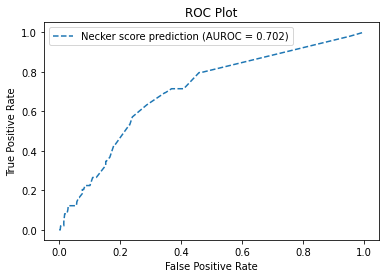

In [49]:
# Plot the ROC curve of IMPACT-score-Necker

sklearn.metrics.roc_curve(y_test, y_prob_1)
r_auc = roc_auc_score(y_test, y_prob_1)
fpr, tpr, _ = roc_curve(y_test, y_prob_1)

plt.plot(fpr, tpr, linestyle='--', label='Necker score prediction (AUROC = %0.3f)' % r_auc)


# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

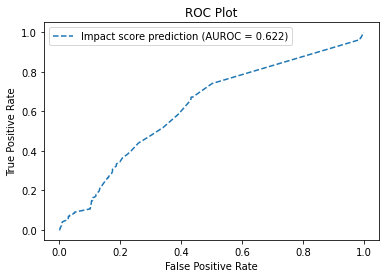

In [50]:
# Plot the ROC curve of IMPACT-score
df_impact = data[['IPP', 'DDK', 'COMPLICATION', 'RISK']]

df_impact.loc[:,'RISK'] = df_impact['RISK']

impact_true = df_impact['COMPLICATION'].to_list()
impact_true = list(map(bool,impact_true))
impact_score = df_impact['RISK'].to_list()

sklearn.metrics.roc_auc_score(impact_true, impact_score)
sklearn.metrics.roc_curve(impact_true, impact_score)
impact_r_auc = roc_auc_score(impact_true, impact_score)
impact_r_fpr, impact_r_tpr, _ = roc_curve(impact_true, impact_score)

impact_r_auc

plt.plot(impact_r_fpr, impact_r_tpr, linestyle='--',
         label='Impact score prediction (AUROC = %0.3f)' % impact_r_auc)


# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

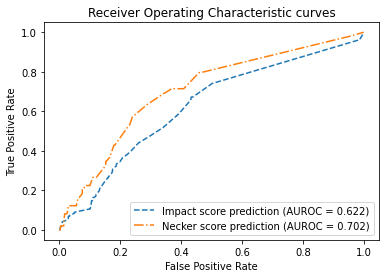

In [51]:
# Compare the ROV curves
plt.plot(impact_r_fpr, impact_r_tpr, linestyle='--',
         label='Impact score prediction (AUROC = %0.3f)' % impact_r_auc)

plt.plot(fpr, tpr, linestyle='-.', 
         label='Necker score prediction (AUROC = %0.3f)' % r_auc)


plt.title("Receiver Operating Characteristic curves")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 

# To save the fig as pdf file
#plt.savefig("roc.pdf", bbox_inches='tight')

Sklearn Impact-score-Necker coefficients

In [52]:
# Target y and explanatory variables x
y = data["COMPLICATION"].cat.codes

x = data[['RISK_CAT1', 'RISK_CAT2', 'RISK_CAT3', 'RISK_CAT4', 'RISK_CAT5', 
           'RISK_CAT6',
           'VUL_HD',
           'IR',
           'VU',
           'COAG_DIS',
           'VUL_HD0',
           'VUL_HD1',
           'VUL_HD2',
           'VUL_HD3']]

In [53]:
# Get the list of coefficients attributed to each explanatory variables

modele_logit = LogisticRegression(penalty='none',solver='newton-cg')
modele_logit.fit(x,y)

result = pd.DataFrame(np.concatenate([modele_logit.intercept_.reshape(-1,1),
                             modele_logit.coef_],axis=1),
                      index = ["coef"],
                      columns = ["constante"]+list(x.columns)).T
#print(result)

# Get OddRatio
import math
OddRatio=np.exp(result['coef'])
print(OddRatio)

constante     0.274112
RISK_CAT1     2.086484
RISK_CAT2     0.406665
RISK_CAT3     0.824177
RISK_CAT4     0.672299
RISK_CAT5     0.488892
RISK_CAT6     0.721451
VUL_HD        0.047037
IR            1.277840
VU            1.892491
COAG_DIS      2.108832
VUL_HD0       0.353842
VUL_HD1      12.758396
VUL_HD2       0.060719
VUL_HD3       1.000000
Name: coef, dtype: float64


In [54]:
## Pour avoir une DF pour R et STATSMODELS
dfy = y.to_frame(name='COMPLICATION')
data = pd.merge(x, dfy, left_index=True, right_index=True)
data.to_csv('datapourR.csv', sep=';', encoding='utf-8')

## STATSMODELS

In [55]:
#Packages
import statsmodels.api as sm
from statsmodels.regression.linear_model import WLS
from statsmodels.genmod.generalized_linear_model import GLM

#from matplotlib import pyplot as plt

In [56]:
# Data
mydata = data

# Format data
mydata = mydata.astype(int)
x = mydata[['RISK_CAT1', 'RISK_CAT2', 'RISK_CAT3', 'RISK_CAT4',
       'RISK_CAT5', 'RISK_CAT6', 'VUL_HD', 'IR', 'VU', 'COAG_DIS', 'VUL_HD0', 
       'VUL_HD1', 'VUL_HD2', 'VUL_HD3']]

# Check that every variable is usefull
print(x.std())

RISK_CAT1    0.078620
RISK_CAT2    0.463776
RISK_CAT3    0.240260
RISK_CAT4    0.334701
RISK_CAT5    0.247678
RISK_CAT6    0.164942
VUL_HD       0.359987
IR           0.359070
VU           0.326466
COAG_DIS     0.285959
VUL_HD0      0.357387
VUL_HD1      0.356709
VUL_HD2      0.026279
VUL_HD3      0.000000
dtype: float64


In [57]:
# remove VUL_HD3 which is = 0
x = mydata[['RISK_CAT1', 'RISK_CAT2', 'RISK_CAT3', 'RISK_CAT4',
       'RISK_CAT5', 'RISK_CAT6', 'VUL_HD', 'IR', 'VU', 'COAG_DIS', 'VUL_HD0', 
       'VUL_HD1', 'VUL_HD2']]

In [58]:
y = mydata[['COMPLICATION']]
y = y.astype("category")
y = y['COMPLICATION'].cat.codes

x_stat = sm.add_constant(x)

model = sm.Logit(y, x_stat)
result = model.fit()

result.summary()

         Current function value: 0.228883
         Iterations: 35


/home/sophie/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 2895
Model:                          Logit   Df Residuals:                     2883
Method:                           MLE   Df Model:                           11
Date:                Fri, 13 Aug 2021   Pseudo R-squ.:                 0.05133
Time:                        13:47:36   Log-Likelihood:                -662.62
converged:                      False   LL-Null:                       -698.47
Covariance Type:            nonrobust   LLR p-value:                 5.772e-11
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2942   2.22e+06  -5.84e-07      1.000   -4.35e+06    4.35e+06
RISK_CAT1      0.7355      0.680      1.081      0.280      -0.598       2.069
RISK_CAT2     -0.8998      0.383     -2.347      0.019      -1.651      -0.148
RISK_CAT3     -0.1934      0.448     -0.432      0.666      -1.071       0.684
RISK_CAT4     -0.3971      0.411     -0.967      0.334      -1.202       0.408
RISK_CAT5     -0.7156      0.481     -1.488      0.137      -1.658       0.227
RISK_CAT6     -0.3265      0.527     -0.619      0.536      -1.360       0.707
VUL_HD        -6.3527   1.41e+07  -4.52e-07      1.000   -2.76e+07    2.76e+07
IR             0.2452      0.192      1.275      0.202      -0.132       0.622
VU             0.6379      0.196      3.250      0.001       0.253       1.023
COAG_DIS       0.7461      0.206      3.621      0.000       0.342       1.150
VUL_HD0       -1.0389   2.22e+06  -4.69e-07      1.000   -4.35e+06    4.35e+06
VUL_HD1        5.8421   1.42e+07   4.11e-07      1.000   -2.79e+07    2.79e+07
VUL_HD2       -6.0974   2.82e+07  -2.16e-07      1.000   -5.53e+07    5.53e+07
==============================================================================
"""

In [59]:
#np.exp(result.params)

In [60]:
params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
#print(np.exp(conf))
res_sum = np.exp(conf)

In [61]:
res_sum

,5%,95%,Odds Ratio
const,0.000000,inf,0.274113
RISK_CAT1,0.550060,7.914432,2.086484
RISK_CAT2,0.191816,0.862161,0.406665
RISK_CAT3,0.342773,1.981685,0.824177
RISK_CAT4,0.300529,1.503968,0.672299
RISK_CAT5,0.190453,1.254987,0.488892
RISK_CAT6,0.256757,2.027172,0.721451
VUL_HD,0.000000,inf,0.001742
IR,0.876715,1.862493,1.277840
VU,1.288119,2.780429,1.892491


In [62]:
res_sum.to_csv('coefficients_statsmodel.csv', sep=';', encoding='utf-8')

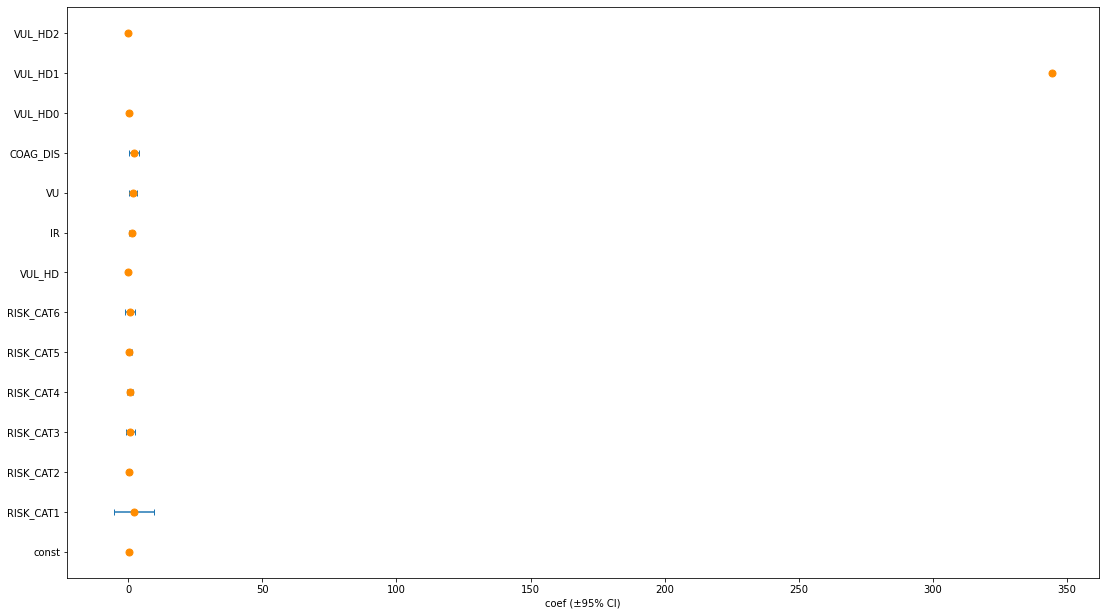

In [63]:
# Plot forest plot

# Confidence intervals
int_conf = res_sum['5%']-res_sum['95%']
int_conf = int_conf.to_numpy()

figure = plt.figure()

plt.errorbar(y=range(len(res_sum)),
            x=res_sum['Odds Ratio'], 
            xerr=int_conf,
            fmt='o',
            capsize=3, markersize=7, mfc="darkorange", mec="darkorange")

plt.yticks(range(len(res_sum)), res_sum.index.tolist())

plt.xlabel('coef (±95% CI)')

figure.set_size_inches(18.5, 10.5)

plt.show()

# To save plot in pdf file
#figure.savefig('forestplot_statmodel.pdf')